In [34]:
# DeepLabV3 architecture with various encoders
# Output stride = 8 (so vary the encoder architecture accordingly)
import tensorflow as tf
import numpy as np
import os

In [37]:
# mount google drive here
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [38]:
dataPath  = '/content/drive/My Drive/Underwater_Segmentation_Research/Data'

trainPath       =  dataPath + '/Train'
testPath        =  dataPath + '/Test'
valPath         =  dataPath + '/Validate'

trainImgsFile   = 'trainingDataImgs.npy'
trainLabelsFile = 'trainingDataLabels.npy'

testImgsFile    = 'testingDataImgs.npy'
testLabelsFile  = 'testingDataLabels.npy'

valImgsFile     = 'validationDataImgs.npy'
valLabelsFile   = 'validationDataLabels.npy'

testImgs = None
testLabels = None

def getData(path,fileName):
  return np.load(path + "/" + fileName)

trainImgs   = getData(trainPath, trainImgsFile)
trainLabels = getData(trainPath, trainLabelsFile)

valImgs    = getData(valPath, valImgsFile)
valLabels  = getData(valPath, valLabelsFile)

print("Got train and validation data")
print(trainImgs.shape, valImgs.shape)
print(trainLabels.shape, valLabels.shape)

Got train and validation data
(1000, 480, 320, 1) (251, 480, 320, 1)
(1000, 480, 320, 1) (251, 480, 320, 1)


In [39]:
class UpdatedMeanIoU(tf.keras.metrics.MeanIoU):
  def __init__(self,
               y_true=None,
               y_pred=None,
               num_classes=None,
               name=None,
               dtype=None):
    super(UpdatedMeanIoU, self).__init__(num_classes = num_classes,name=name, dtype=dtype)

  def update_state(self, y_true, y_pred, sample_weight=None):
    y_pred = tf.math.argmax(y_pred, axis=-1)
    return super().update_state(y_true, y_pred, sample_weight)

In [50]:
vgg16 = tf.keras.applications.VGG16(include_top=False, weights=None, input_tensor=None, input_shape=(480,320,1))

# layer after which changes related to deeplabv3 architecture are made
layerName = 'block4_conv3'

# get the output of this layer and then add new layers after this
block4_conv3 = vgg16.get_layer(layerName).output
block4_pool = tf.keras.layers.MaxPool2D(pool_size=(3,3), strides=1, name='block4_pool', padding='same')(block4_conv3)

# block 5 with Atrous Convolution with rate=2 and maxPooling with stride=1
block5_atrConv1 = tf.keras.layers.Conv2D(512, (3,3), strides=1, dilation_rate=2, padding='same', activation='relu', name='block5_atrConv1')(block4_pool)
block5_atrConv2 = tf.keras.layers.Conv2D(512, (3,3), strides=1, dilation_rate=2, padding='same', activation='relu', name='block5_atrConv2')(block5_atrConv1)
block5_atrConv3 = tf.keras.layers.Conv2D(512, (3,3), strides=1, dilation_rate=2, padding='same', activation='relu', name='block5_atrConv3')(block5_atrConv2)
block5_pool     = tf.keras.layers.MaxPool2D(pool_size=(3,3), strides=1, name='block5_pool', padding='same')(block5_atrConv3)

# Now add the ASPP module
# For that -> create 5 branches -> b0 (conv1x1+relu+bn)256
#                               -> b1 (conv3x3+relu+rate_12 +bn)256
#                               -> b2 (conv3x3 + relu + rate_24 + bn)256
#                               -> b3 (conv3x3 + relu + rate_24 + bn)256
#                               -> b4 (globalAvgPool -> Conv1x1 + relu -> BN + upsample)256
# Then concat all -> apply 1x1 conv 256 + relu + bn -> conv 1x1 12 -> softmax -> bilinear upsampling

output_stride=8

bn_axis=3

b0 = tf.keras.layers.Conv2D(256, (1,1), activation='relu', padding='same', name='aspp_b0')(block5_pool)
b0_BN = tf.keras.layers.BatchNormalization(axis=bn_axis, name='aspp_b0_BN')(b0)

b1 = tf.keras.layers.Conv2D(256, (3,3), dilation_rate=12, activation='relu', padding='same', name='aspp_b1')(block5_pool)
b1_BN = tf.keras.layers.BatchNormalization(axis=bn_axis, name='aspp_b1_BN')(b1)

b2 = tf.keras.layers.Conv2D(256, (3,3), dilation_rate=24, activation='relu', padding='same', name='aspp_b2')(block5_pool)
b2_BN = tf.keras.layers.BatchNormalization(axis=bn_axis, name='aspp_b2_BN')(b2)

b3 = tf.keras.layers.Conv2D(256, (3,3), dilation_rate=36, activation='relu', padding='same', name='aspp_b3')(block5_pool)
b3_BN = tf.keras.layers.BatchNormalization(axis=bn_axis, name='aspp_b3_BN')(b3)

b4 = tf.keras.layers.Conv2D(256, (1,1), activation='relu', padding='same', name='aspp_b4_conv')(tf.keras.layers.AveragePooling2D(name='aspp_b4')(block5_pool))
b4_BN = tf.keras.layers.BatchNormalization(axis=bn_axis, name='aspp_b4_BN')(b4)
b4_up = tf.keras.layers.UpSampling2D(size=(2,2), name='aspp_b4_upsample')(b4_BN)

# now concatenate these outputs
aspp = tf.keras.layers.Concatenate(axis=bn_axis, name='aspp_concatenate')([b0_BN, b1_BN, b2_BN, b4_up])

asppOut_conv1 = tf.keras.layers.Conv2D(256, (1,1), activation='relu', padding='same', name='asppOut_conv1')(aspp)
asppOut_BN    = tf.keras.layers.BatchNormalization(axis=bn_axis, name='asppOut_BN')(asppOut_conv1)

out_small = tf.keras.layers.Conv2D(12, (1,1), activation='softmax', padding='same', name='out_small')(asppOut_BN)
out       = tf.keras.layers.UpSampling2D(size=(8,8), name='output')(out_small)

model = tf.keras.Model(vgg16.input, out)
print(model.summary())

Model: "model_28"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            [(None, 480, 320, 1) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 480, 320, 64) 640         input_7[0][0]                    
__________________________________________________________________________________________________
block1_conv2 (Conv2D)           (None, 480, 320, 64) 36928       block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_pool (MaxPooling2D)      (None, 240, 160, 64) 0           block1_conv2[0][0]               
___________________________________________________________________________________________

In [ ]:
tf.keras.utils.plot_model(model)

In [51]:
import tensorflow as tf
LOSS=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

model.compile('Adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy', UpdatedMeanIoU(num_classes=12)])

In [48]:
# Setup training parameters
BATCH = 16
EPOCHS = 30

# early stopping callback. It stops training when the loss does not change for 3 consecutive epochs
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)

In [52]:
history = model.fit(trainImgs, trainLabels, epochs=EPOCHS, batch_size=BATCH, validation_data=(valImgs, valLabels))

Epoch 1/30
63/63 [==============================] - 78s 1s/step - loss: 1.7613 - accuracy: 0.7480 - updated_mean_io_u_3: 0.0849 - val_loss: 1.2641 - val_accuracy: 0.7335 - val_updated_mean_io_u_3: 0.0731
Epoch 2/30
63/63 [==============================] - 79s 1s/step - loss: 0.3827 - accuracy: 0.9616 - updated_mean_io_u_3: 0.1202 - val_loss: 0.4599 - val_accuracy: 0.9512 - val_updated_mean_io_u_3: 0.1076
Epoch 3/30
63/63 [==============================] - 79s 1s/step - loss: 0.1837 - accuracy: 0.9676 - updated_mean_io_u_3: 0.1244 - val_loss: 0.2330 - val_accuracy: 0.9649 - val_updated_mean_io_u_3: 0.1374
Epoch 4/30
63/63 [==============================] - 75s 1s/step - loss: 0.1354 - accuracy: 0.9684 - updated_mean_io_u_3: 0.1374 - val_loss: 0.3102 - val_accuracy: 0.9621 - val_updated_mean_io_u_3: 0.0820
Epoch 5/30
63/63 [==============================] - 79s 1s/step - loss: 0.1119 - accuracy: 0.9705 - updated_mean_io_u_3: 0.1725 - val_loss: 0.2359 - val_accuracy: 0.9622 - val_updated_

dict_keys(['loss', 'accuracy', 'updated_mean_io_u_3', 'val_loss', 'val_accuracy', 'val_updated_mean_io_u_3'])


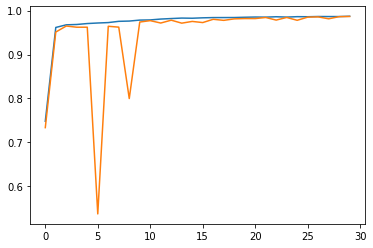

In [53]:
#  Plot the results
print(history.history.keys())

import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])

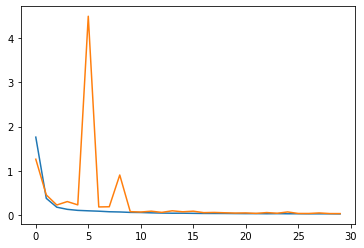

In [54]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

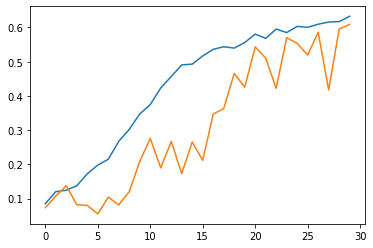

In [56]:
plt.plot(history.history['updated_mean_io_u_3'])
plt.plot(history.history['val_updated_mean_io_u_3'])

In [57]:
# get the testdata
testImgs   = getData(testPath, testImgsFile)
testLabels = getData(testPath, testLabelsFile)

In [58]:
model.evaluate(testImgs, testLabels)

20/20 [==============================] - 38s 1s/step - loss: 0.0348 - accuracy: 0.9869 - updated_mean_io_u_3: 0.6160


[0.034828219562768936, 0.9868962168693542, 0.6159505248069763]

In [60]:
# save the model weights
weightFileName = 'DeepLabV3VggNet16_30e_16b.h5'
weightPath = '/content/drive/My Drive/Underwater_Segmentation_Research/Weights/DeepLabV3'
model.save_weights(weightPath + "/" + weightFileName)

In [62]:
modelFileName = "DeepLabV3VggNet16_30e_16b"
modelPath     = '/content/drive/My Drive/Underwater_Segmentation_Research/Models/DeepLabV3'
model.save(modelPath + "/" + modelFileName)

INFO:tensorflow:Assets written to: /content/drive/My Drive/Underwater_Segmentation_Research/Models/DeepLabV3/DeepLabV3VggNet16_30e_16b/assets


In [63]:
# Check the GPU configuration
!nvidia-smi

Fri Jun 11 18:02:23 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.27       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   73C    P0    34W /  70W |  14570MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
y_preds = model.predict(testImgs)
y_preds = (y_preds >= 0.5).astype(np.uint8)

In [ ]:
yPreds = tf.argmax(y_preds, axis=-1)
yPreds = yPreds.numpy()

In [ ]:
# Compute mean of per-class IOU throughout the test images
num_classes=12
m = UpdatedMeanIoU(num_classes=12)
m.update_state(testLabels, y_preds)

print(f'Overall mean IOU is : {m.result().numpy()}')

# Values is the confusion matrix
values = np.array(m.get_weights()).reshape(num_classes, num_classes)

In [ ]:
# compute the mean per-class IOU
numClasses = 12

classIOU = []

for i in range(numClasses):
  rowSum = np.sum(values[i,:])
  colSum = np.sum(values[:,i])
  denom = rowSum + colSum - values[i,i]
  iou = values[i,i]/denom
  classIOU.append(iou)

print(classIOU)
perClassIoU = np.array(classIOU)
print(np.mean(perClassIoU))

In [ ]:
import matplotlib.pyplot as plt
i = 0
plt.imshow(yPreds[i])
plt.show()

print(np.unique(yPreds[i,:,:]))

plt.imshow(testLabels[i,:,:,0])
plt.show()

print(np.unique(testLabels[i,:,:,0]))

t = np.linspace(0,11,num=12)
plt.plot(t, perClassIoU)
plt.show()